1. Import necessary libraries

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, cross_validate
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, make_scorer
from tqdm import tqdm
from itertools import product

2. Preprocessing and cleaning data

In [2]:
# Load your CSV file
df_Complete = pd.read_csv("/content/Dataset_Spain.csv")

# Check if columns exist
columns_to_check = ['maxspeed', 'lanes', 'surface']

for col in columns_to_check:
    if col in df_Complete.columns:
        print(f"Unique values and counts for '{col}':")
        print(df_Complete[col].value_counts(dropna=False))
        print("\n")
    else:
        print(f"Column '{col}' not found in the CSV.")

<ipython-input-2-0910537d4a6a>:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_Complete = pd.read_csv("/content/Dataset_Spain.csv")


Unique values and counts for 'maxspeed':
maxspeed
NaN                                    418473
50                                      60511
40                                      47115
30                                      27885
90                                      24526
120                                     22861
80                                      15160
60                                      13133
70                                      11248
100                                     10868
20                                       2425
110                                        88
10                                         49
80;90                                      31
50|30                                      23
ES:urban                                   17
80; 90                                     14
5                                          13
25                                         12
signals                                    12
50 mph                        

In [3]:
# -------------------------------
# 1. CLEANING `maxspeed`
# -------------------------------

def clean_maxspeed(val):
    if pd.isna(val):
        return None
    val = str(val).strip().lower()

    # Replace mph values with km/h
    mph_match = re.match(r"(\d+)\s*mph", val)
    if mph_match:
        mph = int(mph_match.group(1))
        return round(mph * 1.60934)  # convert to km/h

    # Remove known non-numeric descriptors
    if val in ["signals", "es:urban"]:
        return None

    # Extract numeric part if delimited (e.g., "80;90", "50|30", etc.)
    parts = re.findall(r"\d+", val)
    if parts:
        return int(max(map(int, parts)))  # choose the max speed listed

    # Extract plain integer
    if val.isdigit():
        return int(val)

    return None  # fallback for strange strings

df_Complete["maxspeed"] = df_Complete["maxspeed"].apply(clean_maxspeed)

# -------------------------------
# 2. CLEANING `lanes`
# -------------------------------

def clean_lanes(val):
    if pd.isna(val):
        return None
    val = str(val).replace(',', '.').strip()  # convert comma to dot
    try:
        lanes = float(val)
        return int(round(lanes))
    except:
        return None

df_Complete["lanes"] = df_Complete["lanes"].apply(clean_lanes)

# -------------------------------
# 3. CLEANING `surface`
# -------------------------------

# Map alternative values and fix typos
surface_map = {
    "asphalt": "asphalt",
    "paved": "paved",
    "sett": "cobblestone",
    "concrete": "concrete",
    "paving_stones": "paving_stones",
    "unhewn_cobblestone": "cobblestone",
    "cobblestone": "cobblestone",
    "chipseal": "chipseal",
    "gravel": "gravel",
    "unpaved": "unpaved",
    "dirt": "dirt",
    "compacted": "compacted",
    "concrete:plates": "concrete",
    "concrete:lanes": "concrete",
    "fine_gravel": "gravel",
    "asphalt_ruts": "asphalt",
    "pebblestone": "gravel",
    "sand": "sand",
    "ground": "ground",
    "metal": "metal",
    "wood": "wood",
    "earth": "dirt",
    "grass": "grass",
    "soil": "dirt",
    "rock": "rock",
    "adoquín": "cobblestone",  # translate from Spanish
    "artificial_turf": "artificial",
    "asphalt;gravel": "asphalt",  # pick dominant surface
}

def clean_surface(val):
    if pd.isna(val):
        return None
    val = str(val).strip().lower()
    val = surface_map.get(val, None)
    return val

df_Complete["surface"] = df_Complete["surface"].apply(clean_surface)

# -------------------------------
# 4. SAVE CLEANED DATA
# -------------------------------

# --- Drop rare values (<= 50 occurrences) ---
for col in ["maxspeed", "lanes", "surface"]:
    value_counts = df_Complete[col].value_counts()
    common_values = value_counts[value_counts > 50].index
    df_Complete = df_Complete[df_Complete[col].isin(common_values)].copy()

In [4]:
# Check if columns exist
columns_to_check = ['maxspeed', 'lanes', 'surface']

for col in columns_to_check:
    if col in df_Complete.columns:
        print(f"Unique values and counts for '{col}':")
        print(df_Complete[col].value_counts(dropna=False))
        print("\n")
    else:
        print(f"Column '{col}' not found in the CSV.")

Unique values and counts for 'maxspeed':
maxspeed
50.0     38655
40.0     25799
30.0     17877
120.0    16572
90.0     12961
80.0      9348
60.0      7427
100.0     7178
70.0      6517
20.0      1419
110.0       64
Name: count, dtype: int64


Unique values and counts for 'lanes':
lanes
2.0    86390
1.0    35078
3.0    15622
4.0     5400
5.0      786
6.0      451
7.0       90
Name: count, dtype: int64


Unique values and counts for 'surface':
surface
asphalt          140210
paved              2909
concrete            285
cobblestone         223
paving_stones       190
Name: count, dtype: int64




In [5]:
# --- Define category label mappings ---
surface_order = ['asphalt', 'cobblestone', 'concrete', 'paved', 'paving_stones']
maxspeed_order = ['20', '30', '40', '50', '60', '70', '80', '90', '100', '110', '120']
lanes_order = ['1', '2', '3', '4', '5', '6', '7']
highway_order = [
    'motorway', 'motorway_link', 'primary', 'primary_link',
    'secondary', 'secondary_link', 'tertiary', 'tertiary_link',
    'trunk', 'trunk_link'
]
clc_order = [
    'Urban Residential', 'Urban Industrial/Commercial', 'Agricultural/Rural',
    'Forested and Natural', 'Sparsely Vegetated/Bare', 'Wetlands & Water Bodies'
]

print(type(df_Complete))

# Convert columns to integers
df_Complete['maxspeed'] = df_Complete['maxspeed'].astype(int)
df_Complete['lanes'] = df_Complete['lanes'].astype(int)

# Encode targets to categorical codes
df_Complete['surface_cat'] = pd.Categorical(
    df_Complete['surface'], categories=surface_order, ordered=True).codes

df_Complete['maxspeed_cat'] = pd.Categorical(
    df_Complete['maxspeed'].astype(str), categories=maxspeed_order, ordered=True).codes

df_Complete['lanes_cat'] = pd.Categorical(
    df_Complete['lanes'].astype(str), categories=lanes_order, ordered=True).codes

# Encode other categorical features with specified order
df_Complete['highway_cat'] = pd.Categorical(
    df_Complete['highway'], categories=highway_order, ordered=True).codes

df_Complete['CLC_Merged_Majority_cat'] = pd.Categorical(
    df_Complete['CLC_Merged_Majority'].map({
        0: 'Urban Residential', 1: 'Urban Industrial/Commercial',
        2: 'Agricultural/Rural', 3: 'Forested and Natural',
        4: 'Sparsely Vegetated/Bare', 5: 'Wetlands & Water Bodies'
    }), categories=clc_order, ordered=True).codes

# Drop columns and fill NaN with 0
df_Complete = df_Complete.drop(columns = ['ID', 'osm_id', 'name', 'Geometry_Midpoint', 'Geometry_LineString', 'highway', 'surface', 'maxspeed', 'lanes', 'CLC_Merged_Majority'])
df_Complete = df_Complete.fillna(0)

# Select numeric columns
numeric_cols = df_Complete.select_dtypes(include=['int64', 'float64']).columns

# Apply 95th percentile clipping
for col in numeric_cols:
    upper_limit = df_Complete[col].quantile(0.95)
    lower_limit = df_Complete[col].quantile(0.05)
    df_Complete[col] = df_Complete[col].clip(lower=lower_limit, upper=upper_limit)
    print(f"{col}: clipped to range {lower_limit:.2f} - {upper_limit:.2f}")

<class 'pandas.core.frame.DataFrame'>
sinuosity: clipped to range 1.00 - 1.14
Average_Slope: clipped to range 0.09 - 11.30
Average_Pop_Density: clipped to range 4.44 - 15286.93
GDP: clipped to range 3646.80 - 239837.00


In [6]:
df_Complete.to_csv('Spain_Cleaned.csv')

3. Visualizing variables range

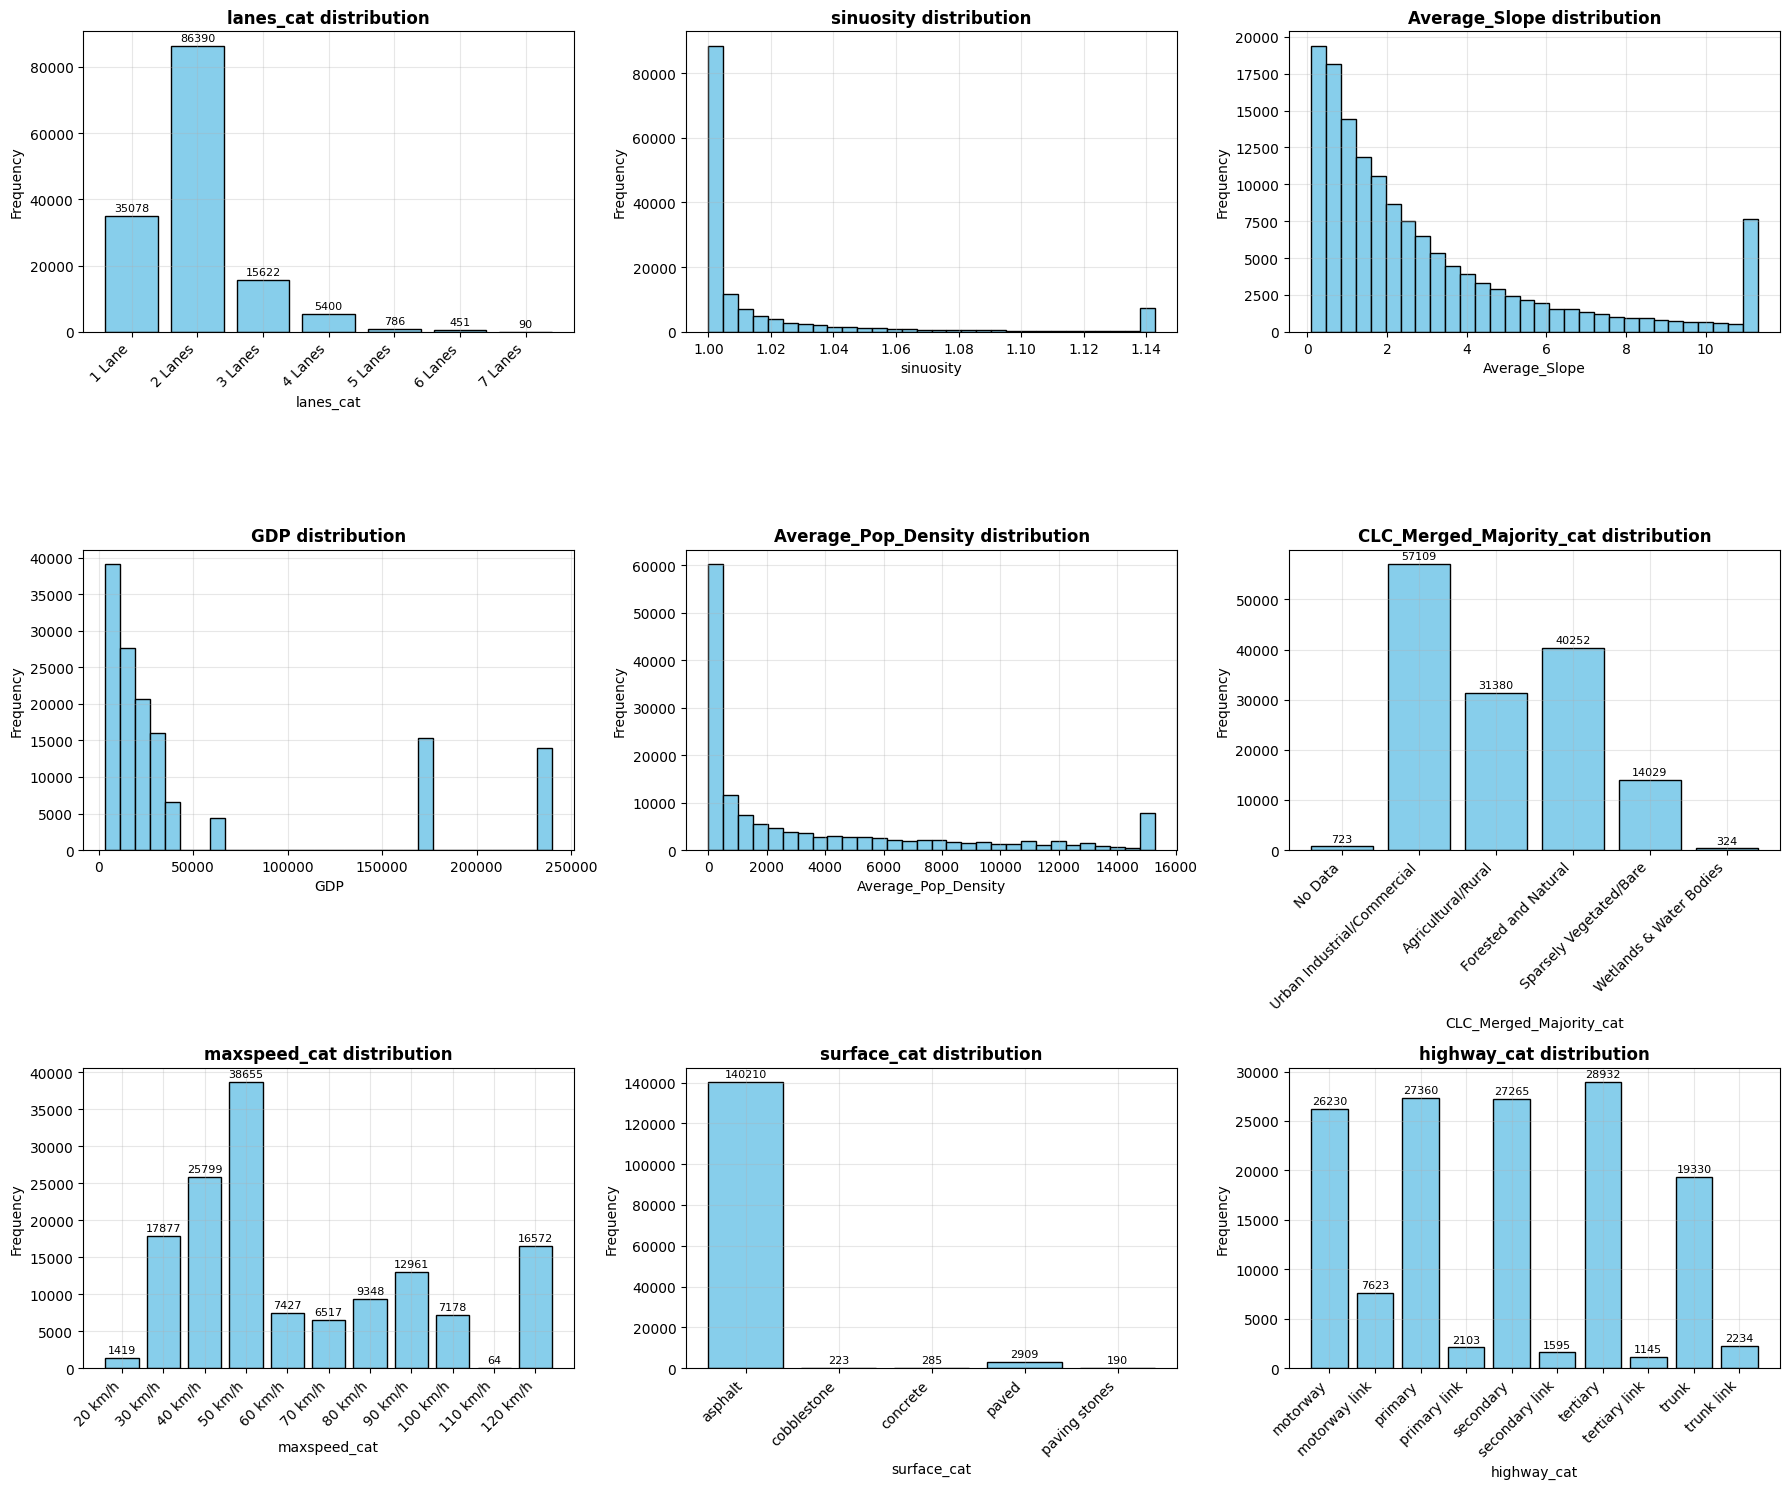

In [7]:
categorical_features = {
    'surface_cat': {
        0: 'asphalt',
        1: 'cobblestone',
        2: 'concrete',
        3: 'paved',
        4: 'paving stones'
    },
    'maxspeed_cat': {
        0: '20 km/h', 1: '30 km/h', 2: '40 km/h', 3: '50 km/h', 4: '60 km/h',
        5: '70 km/h', 6: '80 km/h', 7: '90 km/h', 8: '100 km/h', 9: '110 km/h', 10: '120 km/h'
    },
    'lanes_cat': {
        0: '1 Lane', 1: '2 Lanes', 2: '3 Lanes', 3: '4 Lanes', 4: '5 Lanes', 5: '6 Lanes', 6: '7 Lanes'
    },
    'highway_cat': {
        0: 'motorway', 1: 'motorway link', 2: 'primary', 3: 'primary link',
        4: 'secondary', 5: 'secondary link', 6: 'tertiary', 7: 'tertiary link',
        8: 'trunk', 9: 'trunk link'
    },
    'CLC_Merged_Majority_cat': {
    -1: 'No Data',
    0: 'Urban Residential',
    1: 'Urban Industrial/Commercial',
    2: 'Agricultural/Rural',
    3: 'Forested and Natural',
    4: 'Sparsely Vegetated/Bare',
    5: 'Wetlands & Water Bodies'}
}

features = [
    'lanes_cat', 'sinuosity', 'Average_Slope',
    'GDP', 'Average_Pop_Density', 'CLC_Merged_Majority_cat',
    'maxspeed_cat', 'surface_cat', 'highway_cat']

# --- Plot histograms ---
plt.figure(figsize=(18, 15))
for idx, col in enumerate(features):
    plt.subplot(3, 3, idx + 1)
    if col in categorical_features:
        vc = df_Complete[col].value_counts().sort_index()
        labels = [categorical_features[col].get(code, f"Cat_{code}") for code in vc.index]
        bars = plt.bar(range(len(vc)), vc.values, color='skyblue', edgecolor='black')
        plt.xticks(range(len(vc)), labels, rotation=45, ha='right')
        for bar, val in zip(bars, vc.values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01 * max(vc.values),
                     str(val), ha='center', va='bottom', fontsize=8)
    else:
        df_Complete[col].hist(bins=30, color='skyblue', edgecolor='black')
    plt.title(f'{col} distribution', fontsize=12, fontweight='bold')
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

4. Train Random Forest model

In [8]:
# Base features
base_features = [
    'sinuosity',
    'Average_Slope',
    'CLC_Merged_Majority_cat',
    'GDP',
    'Average_Pop_Density',
    'highway_cat'
]

def train_rf_with_gridsearch(target, features, estimators_list, depths_list):
    print(f"\nTraining Random Forest with GridSearchCV for target: '{target}'")

    X = df_Complete[features]
    y = df_Complete[target]

    # Encode y if it's not numeric
    if y.dtype == 'object' or y.dtype.name == 'category':
        y = LabelEncoder().fit_transform(y)

    # Scoring metrics
    scoring = {
        'accuracy': 'accuracy',
        'precision_weighted': make_scorer(precision_score, average='weighted', zero_division=0),
        'recall_weighted': make_scorer(recall_score, average='weighted', zero_division=0),
        'f1_weighted': make_scorer(f1_score, average='weighted', zero_division=0),
        'roc_auc_ovr_weighted': 'roc_auc_ovr_weighted'
    }

    param_grid = {
        'n_estimators': estimators_list,
        'max_depth': depths_list
    }

    rf = RandomForestClassifier(random_state=42)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        scoring=scoring,
        refit='f1_weighted',
        cv=cv,
        return_train_score=True,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X, y)

    print(f"Best parameters for {target}: {grid_search.best_params_}")
    print(f"Best f1_weighted score: {grid_search.best_score_:.4f}")

    df_cv_results = pd.DataFrame(grid_search.cv_results_)
    df_cv_results = df_cv_results.sort_values(by='mean_test_f1_weighted', ascending=False).reset_index(drop=True)

    return df_cv_results

# Define feature sets per target
features_maxspeed = base_features + ['lanes_cat', 'surface_cat']
features_lanes = base_features + ['maxspeed_cat', 'surface_cat']
features_surface = base_features + ['maxspeed_cat', 'lanes_cat']

# Define hyperparameter grids
estimators_list = [100, 200, 300]
depths_list = [10, 20, None]

# Run training for each target
results_maxspeed = train_rf_with_gridsearch('maxspeed_cat', features_maxspeed, estimators_list, depths_list)
results_lanes = train_rf_with_gridsearch('lanes_cat', features_lanes, estimators_list, depths_list)
results_surface = train_rf_with_gridsearch('surface_cat', features_surface, estimators_list, depths_list)

# Combine and display
all_results = pd.concat([
    results_maxspeed.assign(target='maxspeed_cat'),
    results_lanes.assign(target='lanes_cat'),
    results_surface.assign(target='surface_cat')
], ignore_index=True)

print("\nTop results summary (using StratifiedKFold):")
print(all_results[['target', 'param_n_estimators', 'param_max_depth',
                   'mean_test_accuracy', 'mean_test_precision_weighted',
                   'mean_test_recall_weighted', 'mean_test_f1_weighted',
                   'mean_test_roc_auc_ovr_weighted']]
      .sort_values(by=['target', 'mean_test_f1_weighted'], ascending=[True, False])
      .to_string(index=False, float_format='{:0.4f}'.format))



Training Random Forest with GridSearchCV for target: 'maxspeed_cat'
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters for maxspeed_cat: {'max_depth': None, 'n_estimators': 300}
Best f1_weighted score: 0.6814

Training Random Forest with GridSearchCV for target: 'lanes_cat'
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for lanes_cat: {'max_depth': None, 'n_estimators': 300}
Best f1_weighted score: 0.7420

Training Random Forest with GridSearchCV for target: 'surface_cat'
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters for surface_cat: {'max_depth': None, 'n_estimators': 300}
Best f1_weighted score: 0.9793

Top results summary (using StratifiedKFold):
      target  param_n_estimators param_max_depth  mean_test_accuracy  mean_test_precision_weighted  mean_test_recall_weighted  mean_test_f1_weighted  mean_test_roc_auc_ovr_weighted
   lanes_cat                 300            None              0.7551                        0.7425                     0.7551                 0.7420                          0.8802
   lanes_cat                 200            None              0.7546                        0.7419                     0.7546                 0.7416                          0.8794
   lanes_cat                 100            None              0.7532       

5. Visualize model as confusion matrix and show feature importance

In [12]:
# Define the individual label dictionaries using the mappings from categorical_features
lanes_labels = categorical_features['lanes_cat']
surface_labels = categorical_features['surface_cat']
maxspeed_labels = categorical_features['maxspeed_cat']

label_dicts = {
    'lanes': lanes_labels,
    'surface': surface_labels,
    'maxspeed': maxspeed_labels
}

In [13]:
def plot_confusion_matrix(cm, class_labels, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

def print_confusion_matrix_numpy(cm, class_labels):
    print("Confusion Matrix (rows=actual, columns=predicted):")
    header = "\t" + "\t".join(class_labels)
    print(header)
    for label, row in zip(class_labels, cm):
        print(label + "\t" + "\t".join(map(str, row)))

def skfold_confusion_matrix(X, y, target_name, k=5):
    print(f"\nConfusion Matrix StratifiedK-Fold Evaluation for '{target_name}'")

    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    classes = np.unique(y)
    cm_total = np.zeros((len(classes), len(classes)), dtype=int)

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        cm = confusion_matrix(y_test, y_pred, labels=classes)
        cm_total += cm

    label_map = label_dicts.get(target_name, {int(c): str(c) for c in classes})
    class_labels = [label_map.get(int(c), str(c)) for c in classes]

    # Print confusion matrix as a copy-friendly table
    print_confusion_matrix_numpy(cm_total, class_labels)

    # Plot confusion matrix heatmap
    plot_confusion_matrix(cm_total, class_labels, f"Confusion Matrix for '{target_name}'")

    # Per-class accuracy
    print("\nPer-Class Accuracy:")
    for i, label in enumerate(class_labels):
        total = np.sum(cm_total[i, :])
        correct = cm_total[i, i]
        acc = correct / total if total > 0 else 0
        print(f"{label}: {acc:.4f}")


Confusion Matrix StratifiedK-Fold Evaluation for 'maxspeed'
Confusion Matrix (rows=actual, columns=predicted):
	20 km/h	30 km/h	40 km/h	50 km/h	60 km/h	70 km/h	80 km/h	90 km/h	100 km/h	110 km/h	120 km/h
20 km/h	429	277	288	363	32	4	10	16	0	0	0
30 km/h	50	12326	1418	3758	87	39	44	153	0	0	2
40 km/h	51	1032	18751	3747	636	333	346	765	72	0	66
50 km/h	50	2068	3118	30798	533	398	340	1301	28	1	20
60 km/h	6	114	1467	1173	2850	217	628	760	120	0	92
70 km/h	2	54	1055	1002	315	2175	325	1334	170	0	85
80 km/h	2	54	920	783	583	251	4283	1304	555	5	608
90 km/h	4	61	1101	1033	343	511	584	8776	224	0	324
100 km/h	1	3	158	77	165	126	498	244	3546	4	2356
110 km/h	0	0	0	0	1	0	3	1	12	27	20
120 km/h	0	0	53	10	52	27	165	96	899	7	15263


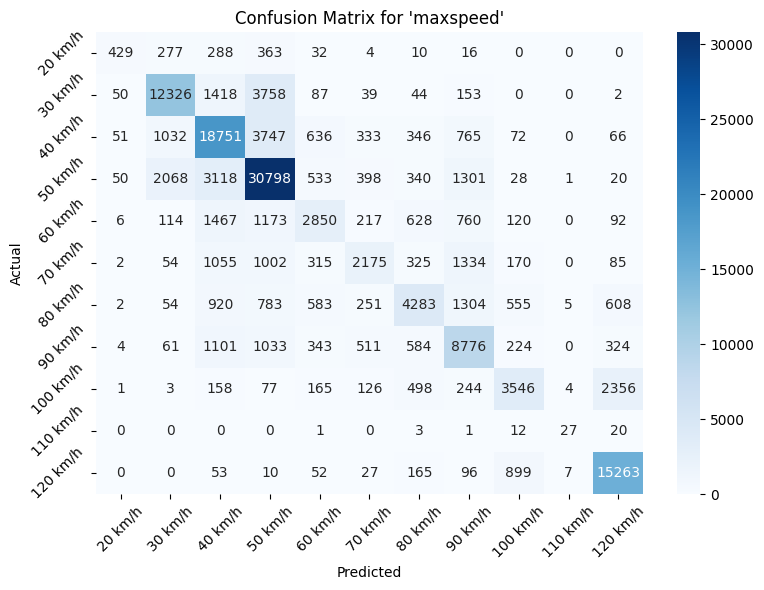


Per-Class Accuracy:
20 km/h: 0.3023
30 km/h: 0.6895
40 km/h: 0.7268
50 km/h: 0.7967
60 km/h: 0.3837
70 km/h: 0.3337
80 km/h: 0.4582
90 km/h: 0.6771
100 km/h: 0.4940
110 km/h: 0.4219
120 km/h: 0.9210

Confusion Matrix StratifiedK-Fold Evaluation for 'lanes'
Confusion Matrix (rows=actual, columns=predicted):
	1 Lane	2 Lanes	3 Lanes	4 Lanes	5 Lanes	6 Lanes	7 Lanes
1 Lane	23078	11694	215	76	12	3	0
2 Lanes	5934	77396	2423	543	44	47	3
3 Lanes	368	7962	6361	769	92	62	8
4 Lanes	129	2217	1395	1491	99	53	16
5 Lanes	14	193	267	155	131	15	11
6 Lanes	4	106	126	79	20	109	7
7 Lanes	0	5	14	25	8	8	30


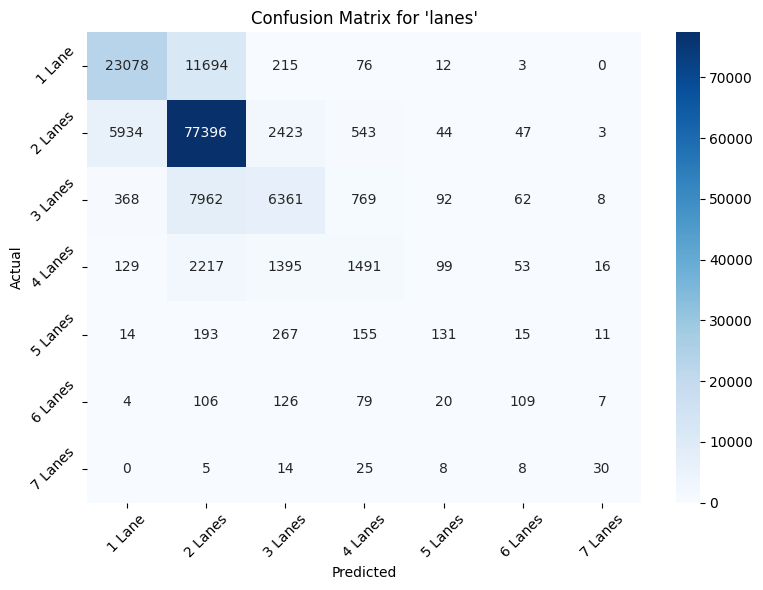


Per-Class Accuracy:
1 Lane: 0.6579
2 Lanes: 0.8959
3 Lanes: 0.4072
4 Lanes: 0.2761
5 Lanes: 0.1667
6 Lanes: 0.2417
7 Lanes: 0.3333

Confusion Matrix StratifiedK-Fold Evaluation for 'surface'
Confusion Matrix (rows=actual, columns=predicted):
	asphalt	cobblestone	concrete	paved	paving stones
asphalt	139960	16	14	208	12
cobblestone	176	46	0	0	1
concrete	249	0	36	0	0
paved	1650	0	0	1259	0
paving stones	153	2	0	0	35


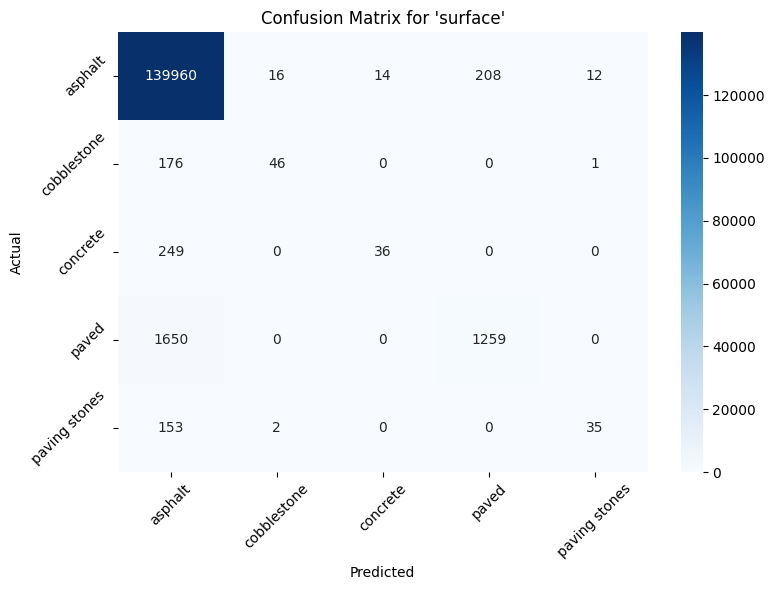


Per-Class Accuracy:
asphalt: 0.9982
cobblestone: 0.2063
concrete: 0.1263
paved: 0.4328
paving stones: 0.1842


In [14]:
# Confusion Matrices
skfold_confusion_matrix(df_Complete[features_maxspeed], df_Complete['maxspeed_cat'], 'maxspeed')
skfold_confusion_matrix(df_Complete[features_lanes], df_Complete['lanes_cat'], 'lanes')
skfold_confusion_matrix(df_Complete[features_surface], df_Complete['surface_cat'], 'surface')

In [15]:
def plot_feature_importances(X, y, target_name, n_estimators=300, max_depth=None):
    print(f"\nFeature Importances for '{target_name}'")
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    model.fit(X, y)

    sorted_idx = model.feature_importances_.argsort()

    plt.figure(figsize=(8, 6))
    plt.barh(X.columns[sorted_idx], model.feature_importances_[sorted_idx], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importances for "{target_name}"')
    plt.tight_layout()
    plt.grid(True, alpha=0.7)
    plt.show()

    # Also return a sorted DataFrame of feature importances
    importances_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False).reset_index(drop=True)

    return importances_df


Feature Importances for 'maxspeed_cat'


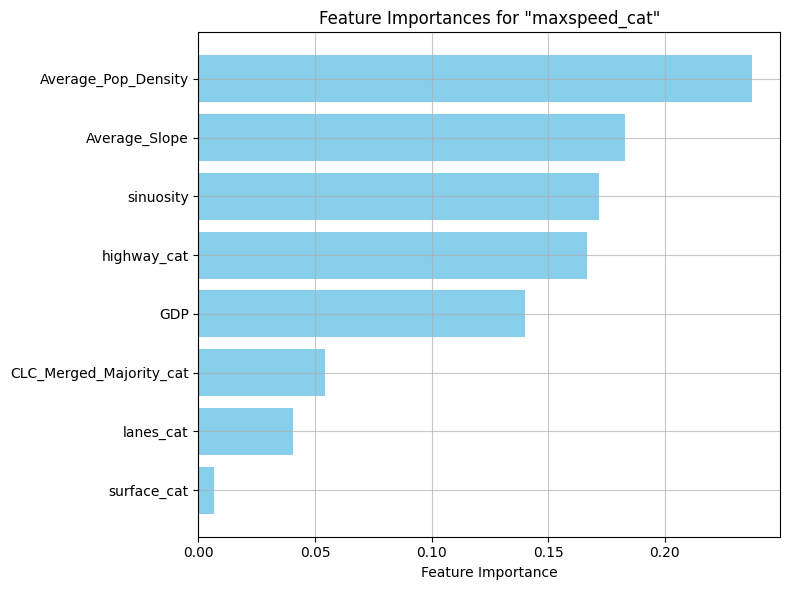


Feature Importances for 'lanes_cat'


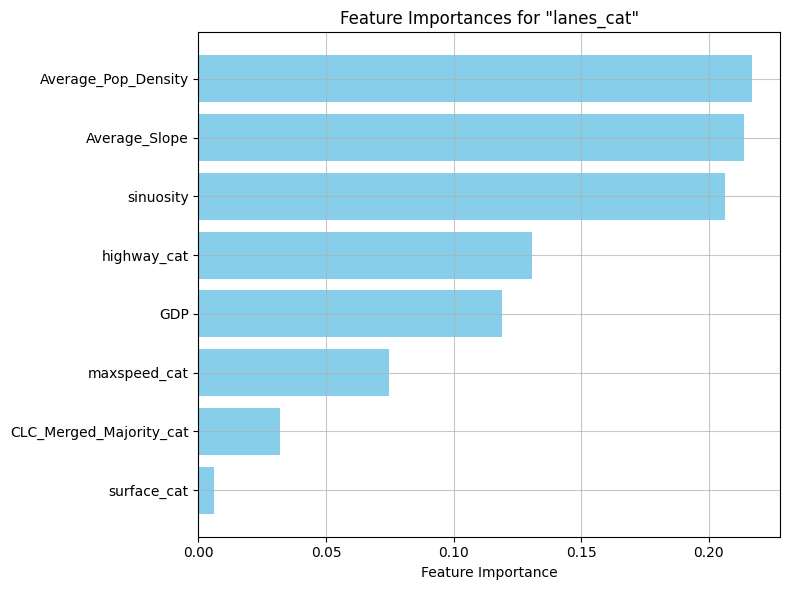


Feature Importances for 'surface_cat'


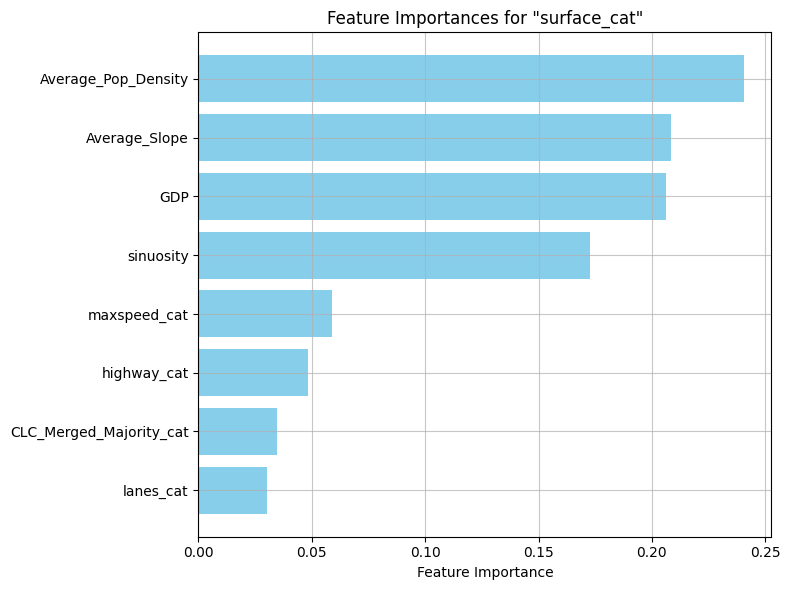

In [16]:
# Feature sets (you already defined these)
X_maxspeed = df_Complete[features_maxspeed]
y_maxspeed = df_Complete['maxspeed_cat']

X_lanes = df_Complete[features_lanes]
y_lanes = df_Complete['lanes_cat']

X_surface = df_Complete[features_surface]
y_surface = df_Complete['surface_cat']

# Run and get importance DataFrames
importances_maxspeed = plot_feature_importances(X_maxspeed, y_maxspeed, 'maxspeed_cat')
importances_lanes = plot_feature_importances(X_lanes, y_lanes, 'lanes_cat')
importances_surface = plot_feature_importances(X_surface, y_surface, 'surface_cat')
